<div style="background-color: #ffffff; color: #333; padding: 15px; border: 1px solid #ddd; border-radius: 8px;">
    <a class="anchor" id="1st-bullet"></a>
    <h2 style="color: #795548; font-weight: bold; text-align: center;">Group Project - Data Preprocessing</h2>
    <h3 style="color: #a1887f; text-align: center;">Data Mining 2024/2025</h3>
</div>

<div style="text-align: center;">
    <strong>Group 14</strong>
    <table style="margin: 0 auto; border-collapse: collapse; border: 1px solid black;">
        <tr>
            <th style="border: 1px solid white; padding: 8px;">Name</th>
            <th style="border: 1px solid white; padding: 8px;">Student ID</th>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Francisco Santos</td>
            <td style="border: 1px solid white; padding: 8px;">20240562</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Margarida Raposo</td>
            <td style="border: 1px solid white; padding: 8px;">20241020</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Nuno Nunes</td>
            <td style="border: 1px solid white; padding: 8px;">20240560</td>
        </tr>
        <tr>
            <td style="border: 1px solid white; padding: 8px;">Teresa Menezes</td>
            <td style="border: 1px solid white; padding: 8px;">20240333</td>
        </tr>
    </table>
</div>

### **Structure**
1. [Data Preparation](#add)
2. [Missing Values](#add)
3. [Outliers](#add)
3. Feature Engineering ? https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering

In [1]:
import pandas as pd
import numpy as np

# import matplotlib.pyplot and seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import os
from math import ceil

from scipy import stats

import warnings

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors

########### for what?
from kneed import KneeLocator

########### for what?
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('df1.csv', index_col='customer_id')

## Data Preparation

In [3]:
# exclude customers with no orders
no_orders = df.loc[:, 'DOW_0':'DOW_6'].sum(axis=1) == 0
no_orders = df[no_orders]

In [4]:
# new dataframe with only customers who have ordered
df_customers = df[~df.index.isin(no_orders.index)]

### Missing Values

In [5]:
# get the total number of NaN values for each column
total_nan = df_customers.isna().sum().sort_values(ascending=False)

# get the percentage of NaN values for each column
percent_nan = ((total_nan / len(df_customers)) * 100).round(2)

# create a DataFrame to display the total and percentage of NaN values for each column
nan_stats = pd.DataFrame({'Total NaN': total_nan, 'Percentage NaN': percent_nan})

# no need to display columns with no NaN values
nan_stats = nan_stats[nan_stats['Total NaN'] > 0]

nan_stats

,Total NaN,Percentage NaN
HR_0,1164,3.67
customer_age,727,2.29
age_group,727,2.29
first_order,106,0.33


- Low %, so lets use imputation

- Same % for 'customer_age' and 'age_group' -> NaN values in age_group are probably due to missing values in customer_age

**HR_0**

In [6]:
# ignore warnings
warnings.filterwarnings('ignore')

# sum of columns from DOW_0 to DOW_6
dow_sum = df_customers.loc[:, 'DOW_0':'DOW_6'].sum(axis=1)
# sum of columns from HR_0 to HR_23 
hr_sum = df_customers.loc[:, 'HR_0':'HR_23'].sum(axis=1)

# calculate the difference: dow_sum - hr_sum
difference = dow_sum - hr_sum
# fill missing values in HR_0 with the calculated 'difference'
df_customers['HR_0'].fillna(difference, inplace=True)

**Customer Age and Age Group**

In [7]:
# Check if missing age_group aligns with missing customer_age
missing_consistency = df_customers[df_customers['customer_age'].isnull()]['age_group'].isnull().all()
print(f"Are all missing age_group values tied to missing customer_age? {missing_consistency}")

Are all missing age_group values tied to missing customer_age? True


Text(0.5, 1.0, 'Distribution of Customer Age')

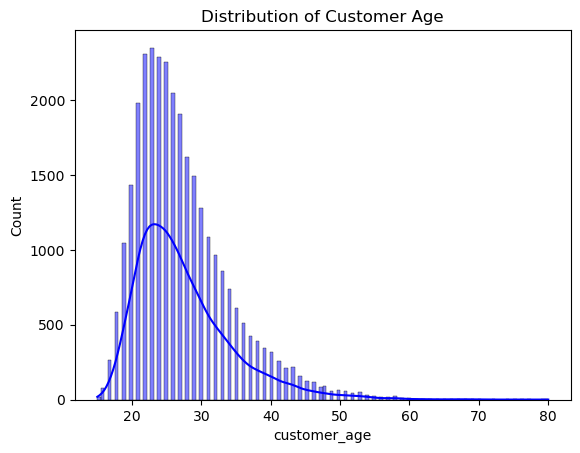

In [8]:
# get distribution of the 'customer_age' column
sns.histplot(df_customers['customer_age'], kde=True, color='blue')
plt.title('Distribution of Customer Age')


- Distribution is right-skewed, let's use the median over the mean

In [9]:
# ignore warnings
warnings.filterwarnings('ignore')

# fill customer_age with the median value
customer_age_median = df_customers['customer_age'].median()  # 26
df_customers['customer_age'].fillna(customer_age_median, inplace=True)

# fill age_group with the respective age group (21-30)
df_customers['age_group'].fillna('21-30', inplace=True)

**First_Order** 
- Impute with the mean, median or mode doesn't make sense here. As those missing values represent 0.33% let's drop them

In [10]:
# ignore warnings
warnings.filterwarnings('ignore')

# drop rows where first_order is missing
df_customers.dropna(subset=['first_order'], inplace=True)

## Outliers

In [11]:
# metric features
metric_features = df_customers.select_dtypes(include=[np.number]).columns

In [12]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_customers[metric_features])

In [13]:
# Using DBScan for Outlier detection:

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)

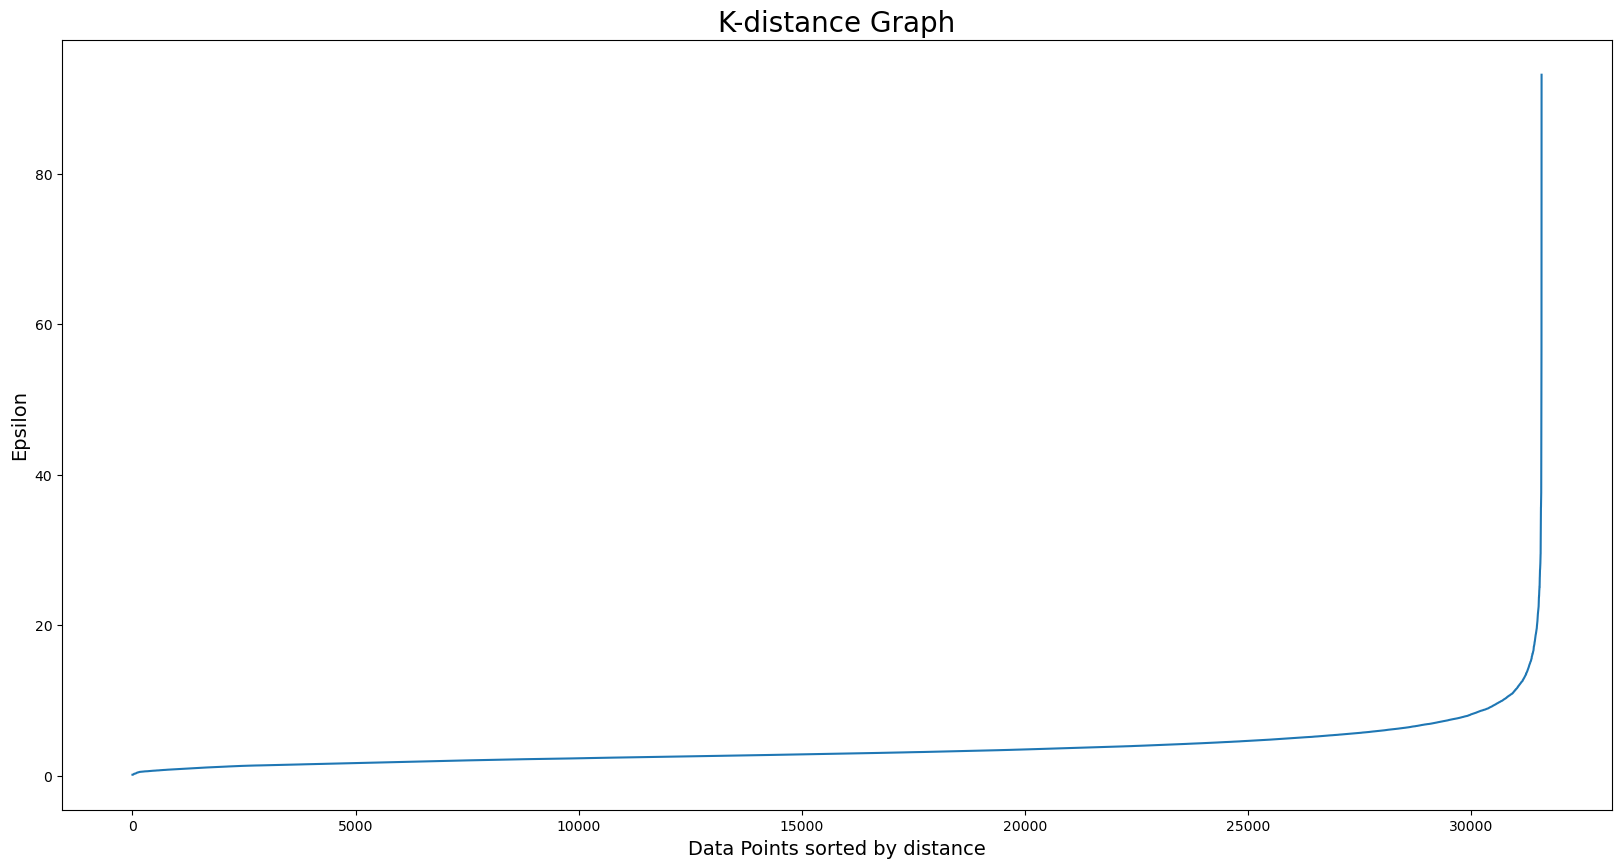

In [14]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [15]:
# distances would be your sorted distance values
kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve='convex', direction='increasing')

# The elbow point:
elbow_point = kneedle.elbow
print("The elbow point is:", elbow_point)

epsilon = distances[kneedle.elbow]
print("The epsilon value at the elbow point is:", epsilon)

The elbow point is: 31444
The epsilon value at the elbow point is: 18.362300202236078


In [16]:
# Define specific `min_samples` values to test
min_samples_values = [len(metric_features) + 1, 2*len(metric_features),3*len(metric_features)]

# Initialize lists to store the metrics
silhouette_scores = []

# Loop over the specified `min_samples` values
for min_samples in min_samples_values:
    # Run DBSCAN
    db = DBSCAN(eps=17.6778753865531, min_samples=min_samples)
    labels = db.fit_predict(data_scaled)
    
    # Calculate metrics for clusters that have more than one element and not just noise
    if len(set(labels)) > 1 and -1 in labels:
        silhouette_avg = silhouette_score(data_scaled, labels)
        
        # Append metrics to the lists
        silhouette_scores.append(silhouette_avg)

    else:
        # If there's only one cluster or all points are noise, metrics are not meaningful
        silhouette_scores.append(None)

# Print the results
for ms, ss in zip(min_samples_values, silhouette_scores):
    print(f"min_samples: {ms}, Silhouette Score: {ss}")


min_samples: 64, Silhouette Score: 0.7683884706827985
min_samples: 126, Silhouette Score: 0.7666832628524702
min_samples: 189, Silhouette Score: 0.7656090401705261


In [17]:
epsilon = 17.6778753865531

min_points = len(metric_features) + 1 # by convention the min_points has to be at least the nr of metric features plus 1. Indeed 59 + 1 was the one providing the highest silhouette score according to the above output

In [18]:
model = DBSCAN(eps = epsilon, min_samples = min_points).fit(data_scaled)

In [19]:
# outliers dataframe
outliers = data_scaled[model.labels_ == -1]
outliers

array([[ 1.62728046,  0.67694265,  3.629081  , ..., -0.86322211,
         3.40326512,  0.96401293],
       [ 0.92151988,  0.31625374, 12.81213685, ...,  0.83025482,
         8.10890532, -1.23911354],
       [ 1.62728046,  4.64452071,  8.36409417, ...,  0.09485618,
         5.73905712,  0.04034189],
       ...,
       [-0.91345762,  2.84107614,  4.63347773, ...,  2.0437308 ,
         1.51186546, -1.04753733],
       [-0.91345762,  8.61209876,  7.93363843, ..., -0.5007737 ,
         4.95891926,  0.64861307],
       [-0.06654493,  3.92314288,  5.49438922, ..., -0.60360825,
         2.83950103,  0.132709  ]])

In [20]:
# Calculate the number of data points in the original dataset
original_data_count = len(data_scaled)

# Calculate the number of data points identified as outliers
outliers_count = len(data_scaled[model.labels_ == -1])

# Calculate the percentage of data that are outliers
outliers_percentage = (outliers_count / original_data_count) * 100

print(f"Percentage of data identified as outliers: {outliers_percentage:.2f}%")

Percentage of data identified as outliers: 0.58%


In [21]:
data_no_outliers = data_scaled[model.labels_ != -1]

In [22]:
data_no_outliers = pd.DataFrame(data_no_outliers, columns=metric_features)
data_no_outliers

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,...,customer_city,total_orders,days_since_last_order,vendor_loyalty_score,cuisine_variety,available_cuisines_city,relative_cuisine_variety,average_spending,order_frequency,chain_consumption
0,-1.336914,-0.405124,-0.101535,-0.460631,-1.179582,-2.746186,-0.419982,-0.424012,-0.271954,-0.125188,...,-1.060623,-0.471133,-2.746186,-0.076298,-0.870670,1.151593,-1.080237,0.528089,22.754035,-0.329127
1,-1.478066,-0.405124,-0.531991,-0.209876,-1.179582,-2.746186,0.676943,-0.153769,-0.271954,-0.125188,...,1.338483,-0.471133,-2.746186,-0.076298,-0.195411,-1.281334,0.378789,-0.087778,22.754035,0.964013
2,1.486128,-0.765813,-0.531991,-0.209876,-1.179582,-2.746186,0.367203,-0.424012,-0.271954,-0.125188,...,-0.260921,-0.471133,-2.746186,1.472881,-0.870670,0.108910,-0.947598,-0.725299,22.754035,0.964013
3,-0.207697,-0.405124,-0.388506,-0.460631,-1.179582,-2.702571,-0.419982,0.155382,-0.271954,-0.125188,...,-0.260921,-0.471133,-2.702571,-0.076298,-0.195411,0.108910,-0.284404,0.698774,10.938078,-0.329127
4,-1.054610,-0.405124,-0.101535,-0.711387,-1.179582,-2.702571,0.826679,1.304442,-0.271954,-0.125188,...,-0.260921,-0.471133,-2.702571,-0.076298,-0.195411,0.108910,-0.284404,2.219652,10.938078,-1.622266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31396,6.567604,-0.765813,-0.675476,-0.460631,2.518094,1.091982,-0.419982,-0.424012,-0.271954,-0.125188,...,-1.060623,-0.667500,1.091982,1.472881,-0.870670,1.151593,-1.080237,-1.088322,-0.745115,0.964013
31397,-0.207697,-0.765813,-0.675476,-0.460631,2.518094,1.091982,-0.419982,-0.424012,-0.271954,-0.125188,...,-1.060623,-0.667500,1.091982,1.472881,-0.870670,1.151593,-1.080237,-1.074311,-0.745115,0.964013
31398,-1.054610,-0.765813,-0.531991,-0.711387,2.518094,1.091982,-0.419982,-0.424012,-0.271954,-0.125188,...,-0.260921,-0.667500,1.091982,1.472881,-0.870670,0.108910,-0.947598,1.637540,-0.745115,-1.622266
31399,-0.772306,-0.765813,-0.388506,-0.460631,2.518094,1.091982,-0.419982,-0.424012,-0.271954,-0.125188,...,-0.260921,-0.667500,1.091982,1.472881,-0.870670,0.108910,-0.947598,1.492331,-0.745115,0.964013


In [23]:
data_no_outliers.to_csv('df2.csv', index=True)